## Configuration, Autentication and Libraries Importation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linspace
from ipywidgets import interact, FloatSlider
sns.set()

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
#@title Enter Google Cloud/BigQuery Project ID
project_id = 'casegbtech.Case_DB' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client()

## Database Data Access

In [7]:
dataset_ref = bq_client.dataset("Case_DB", project="casegbtech")
dataset = bq_client.get_dataset(dataset_ref)

In [8]:
pedidos_ref = dataset_ref.table("Pedidos")
fraude_ref = dataset_ref.table("Fraude")
backtest_ref = dataset_ref.table("Backtest")

In [9]:
ped_table = bq_client.get_table(pedidos_ref)
bq_client.list_rows(ped_table, max_results=20).to_dataframe()

,Pedido,Valor,Regiao,Score,Status
0,441,207,Sul,1,Aprovado
1,863,106,Sul,1,Aprovado
2,881,199,Sul,1,Aprovado
3,828,192,Sul,2,Aprovado
4,137,192,Sul,4,Aprovado
5,177,103,Sul,4,Aprovado
6,670,220,Sul,4,Aprovado
7,139,216,Sul,5,Aprovado
8,190,246,Sul,5,Aprovado
9,398,158,Sul,5,Aprovado


In [10]:
fraude_table = bq_client.get_table(fraude_ref)
bq_client.list_rows(fraude_table, max_results=20).to_dataframe()

,Pedido,Fraude
0,11,1
1,53,1
2,110,1
3,128,1
4,151,1
5,154,1
6,167,1
7,168,1
8,174,1
9,246,1


In [11]:
back_table = bq_client.get_table(backtest_ref)
bq_client.list_rows(back_table, max_results=20).to_dataframe()

,Pedido,novo score,novo status
0,224,1,Aprovado
1,270,1,Aprovado
2,298,1,Aprovado
3,350,1,Aprovado
4,380,1,Aprovado
5,743,1,Aprovado
6,894,1,Aprovado
7,900,1,Aprovado
8,212,2,Aprovado
9,562,2,Aprovado


# Joining Data

In [12]:
bq_client = bigquery.Client('casegbtech')

In [13]:
Ped_Fraude_query = """SELECT p.Pedido, p.Valor, p.Regiao, p.Score, b.`novo score`, p.status, b.`novo status`, f.Fraude,
                  FROM `casegbtech.Case_DB.Pedidos` as p
                  LEFT JOIN `casegbtech.Case_DB.Fraude` as f
                    ON p.Pedido = f.Pedido
                  LEFT JOIN `casegbtech.Case_DB.Backtest` as b
                    ON p.Pedido = b.Pedido
                   """

Ped_Fraude_query_job = bq_client.query(Ped_Fraude_query)

df_fraudes = Ped_Fraude_query_job.to_dataframe()

In [14]:
df_fraudes

,Pedido,Valor,Regiao,Score,novo score,status,novo status,Fraude
0,441,207,Sul,1,17,Aprovado,Aprovado,<NA>
1,863,106,Sul,1,47,Aprovado,Aprovado,<NA>
2,881,199,Sul,1,14,Aprovado,Aprovado,<NA>
3,828,192,Sul,2,42,Aprovado,Aprovado,<NA>
4,137,192,Sul,4,59,Aprovado,Aprovado,<NA>
...,...,...,...,...,...,...,...,...
995,57,249,Centro-Oeste,99,54,Reprovado,Aprovado,<NA>
996,83,223,Centro-Oeste,99,48,Reprovado,Aprovado,<NA>
997,114,224,Centro-Oeste,100,6,Reprovado,Aprovado,<NA>
998,779,160,Centro-Oeste,100,69,Reprovado,Aprovado,<NA>


## Descriptive Analysis

### Current state

Contagem de pedidos

In [15]:
total_pedidos = df_fraudes.shape[0]
print(f"Total de Pedidos: {total_pedidos}")

Total de Pedidos: 1000


Taxa de Aprovação Atual

In [16]:
taxa_aprovacao_atual = df_fraudes[df_fraudes['status'] == 'Aprovado'].shape[0] / total_pedidos * 100
print(f"Taxa de Aprovação Atual: {taxa_aprovacao_atual:.2f}%")

Taxa de Aprovação Atual: 87.90%


Taxa de Fraudes

In [17]:
# Substituindo valores nulos na coluna 'Fraude' por 0
df_fraudes['Fraude'].fillna(0, inplace=True)

# Convertendo a coluna 'Fraude' para inteiro para facilitar a análise
df_fraudes['Fraude'] = df_fraudes['Fraude'].astype(int)


In [18]:
taxa_fraude = df_fraudes[df_fraudes['Fraude'] == 1].shape[0] / total_pedidos * 100
print(f"Taxa de Fraude: {taxa_fraude:.2f}%")


Taxa de Fraude: 3.60%


Análise de fraudes aprovadas

In [19]:
fraudes_aprovadas = df_fraudes[(df_fraudes['Fraude'] == 1) & (df_fraudes['status'] == 'Aprovado')]
total_fraudes_aprovadas = fraudes_aprovadas.shape[0]
print(f"Total de Fraudes Aprovadas: {total_fraudes_aprovadas}")

# Taxa de fraudes que passaram pela aprovação
total_fraudes = df_fraudes[df_fraudes['Fraude'] == 1].shape[0]
taxa_fraude = total_fraudes / total_pedidos * 100
print(f"Taxa de Fraude Aprovadas: {taxa_fraude:.2f}%")

Total de Fraudes Aprovadas: 36
Taxa de Fraude Aprovadas: 3.60%


Análise de Pedidos Aprovados

In [20]:
pedidos_aprovados = df_fraudes[df_fraudes['status'] == 'Aprovado']

# Verificando a quantidade de pedidos reprovados
total_reprovados = pedidos_aprovados.shape[0]
print(f"Total de Pedidos Aprovado: {total_reprovados}")

Total de Pedidos Aprovado: 879


In [21]:
valor_total_aprovados = pedidos_aprovados['Valor'].sum()
media_valor_aprovados = pedidos_aprovados['Valor'].mean()
mediana_valor_aprovados = pedidos_aprovados['Valor'].median()
desvio_padrao_valor_aprovados = pedidos_aprovados['Valor'].std()

print(f"Valor Total dos Pedidos aprovados: R${valor_total_aprovados:.2f}")
print(f"Média do Valor dos Pedidos aprovados: R${media_valor_aprovados:.2f}")
print(f"Mediana do Valor dos Pedidos aprovados: R${mediana_valor_aprovados:.2f}")
print(f"Desvio Padrão do Valor dos Pedidos aprovados: R${desvio_padrao_valor_aprovados:.2f}")

Valor Total dos Pedidos aprovados: R$175335.00
Média do Valor dos Pedidos aprovados: R$199.47
Mediana do Valor dos Pedidos aprovados: R$200.00
Desvio Padrão do Valor dos Pedidos aprovados: R$56.72


Análise de Pedidos Reprovados

In [22]:
# Filtrando pedidos reprovados
pedidos_reprovados = df_fraudes[df_fraudes['status'] == 'Reprovado']

# Verificando a quantidade de pedidos reprovados
total_reprovados = pedidos_reprovados.shape[0]
print(f"Total de Pedidos Reprovados: {total_reprovados}")


Total de Pedidos Reprovados: 121


In [23]:
valor_total_reprovados = pedidos_reprovados['Valor'].sum()
media_valor_reprovados = pedidos_reprovados['Valor'].mean()
mediana_valor_reprovados = pedidos_reprovados['Valor'].median()
desvio_padrao_valor_reprovados = pedidos_reprovados['Valor'].std()

print(f"Valor Total dos Pedidos Reprovados: R${valor_total_reprovados:.2f}")
print(f"Média do Valor dos Pedidos Reprovados: R${media_valor_reprovados:.2f}")
print(f"Mediana do Valor dos Pedidos Reprovados: R${mediana_valor_reprovados:.2f}")
print(f"Desvio Padrão do Valor dos Pedidos Reprovados: R${desvio_padrao_valor_reprovados:.2f}")


Valor Total dos Pedidos Reprovados: R$24314.00
Média do Valor dos Pedidos Reprovados: R$200.94
Mediana do Valor dos Pedidos Reprovados: R$204.00
Desvio Padrão do Valor dos Pedidos Reprovados: R$53.78


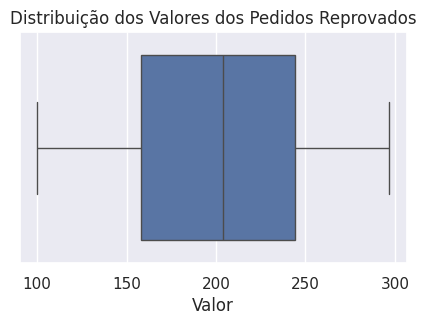

In [24]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='Valor', data=pedidos_reprovados)
plt.title('Distribuição dos Valores dos Pedidos Reprovados')
plt.xlabel('Valor')
plt.show()


## Proposed Model





Análise de Custo (custo de R$ 6,00 por transação avaliada)

In [25]:
custo_total = total_pedidos * 6
print(f"Custo total da implementação: R${custo_total:.2f}")

Custo total da implementação: R$6000.00


Taxa de aprovação do novo modelo

In [26]:
taxa_aprovacao_novo = df_fraudes[df_fraudes['novo status'] == 'Aprovado'].shape[0] / total_pedidos * 100
print(f"Taxa de Aprovação do novo modelo: {taxa_aprovacao_novo:.2f}%")

print(f"Aumento de Aprovação: {taxa_aprovacao_novo-taxa_aprovacao_atual:.2f}%")
print("Aumento maior que 4.4 p.p.")

Taxa de Aprovação do novo modelo: 92.60%
Aumento de Aprovação: 4.70%
Aumento maior que 4.4 p.p.


Taxa de Fraudes Aprovadas

In [27]:
fraudes_aprovadas_novo = df_fraudes[(df_fraudes['Fraude'] == 1) & (df_fraudes['novo status'] == 'Aprovado')]
total_fraudes_aprovadas_novo = fraudes_aprovadas_novo.shape[0]
print(f"Total de Fraudes Aprovadas: {total_fraudes_aprovadas_novo}")

# Taxa de fraudes que passaram pela aprovação
total_fraudes_novo = df_fraudes[df_fraudes['Fraude'] == 1].shape[0]
taxa_fraude_novo = total_fraudes_novo / total_pedidos * 100
print(f"Taxa de Fraude Aprovadas: {taxa_fraude_novo:.2f}%")
print('Mesma quantidade de Fraudes Aprovadas')

Total de Fraudes Aprovadas: 36
Taxa de Fraude Aprovadas: 3.60%
Mesma quantidade de Fraudes Aprovadas


Análise de Pedidos Aprovados

In [28]:
pedidos_aprovados_novo = df_fraudes[df_fraudes['novo status'] == 'Aprovado']

# Verificando a quantidade de pedidos reprovados
total_reprovados_novo = pedidos_aprovados_novo.shape[0]
print(f"Total de Pedidos Aprovados: {total_reprovados_novo}")

Total de Pedidos Aprovados: 926


In [29]:
valor_total_aprovados_novo = pedidos_aprovados_novo['Valor'].sum()
media_valor_aprovados_novo = pedidos_aprovados_novo['Valor'].mean()
mediana_valor_aprovados_novo = pedidos_aprovados_novo['Valor'].median()
desvio_padrao_valor_aprovados_novo = pedidos_aprovados_novo['Valor'].std()

print(f"Valor Total dos Pedidos aprovados: R${valor_total_aprovados_novo:.2f}")
print(f"Média do Valor dos Pedidos aprovados: R${media_valor_aprovados_novo:.2f}")
print(f"Mediana do Valor dos Pedidos aprovados: R${mediana_valor_aprovados_novo:.2f}")
print(f"Desvio Padrão do Valor dos Pedidos aprovados: R${desvio_padrao_valor_aprovados_novo:.2f}")

Valor Total dos Pedidos aprovados: R$184749.00
Média do Valor dos Pedidos aprovados: R$199.51
Mediana do Valor dos Pedidos aprovados: R$200.00
Desvio Padrão do Valor dos Pedidos aprovados: R$56.37


Taxa de Pedidos Reprovados

In [30]:
pedidos_reprovados_novo = df_fraudes[df_fraudes['novo status'] == 'Reprovado']

# Verificando a quantidade de pedidos reprovados
total_reprovados_novo = pedidos_reprovados_novo.shape[0]
print(f"Total de Pedidos Reprovados: {total_reprovados_novo}")
print(f"Total de Pedidos Reprovados a menos: {total_reprovados-total_reprovados_novo}")

Total de Pedidos Reprovados: 74
Total de Pedidos Reprovados a menos: 47


In [31]:
valor_total_reprovados_novo = pedidos_reprovados_novo['Valor'].sum()
media_valor_reprovados_novo = pedidos_reprovados_novo['Valor'].mean()
mediana_valor_reprovados_novo = pedidos_reprovados_novo['Valor'].median()
desvio_padrao_valor_reprovados_novo = pedidos_reprovados_novo['Valor'].std()

print(f"Valor Total dos Pedidos Reprovados: R${valor_total_reprovados_novo:.2f}")
print(f"Média do Valor dos Pedidos Reprovados: R${media_valor_reprovados_novo:.2f}")
print(f"Mediana do Valor dos Pedidos Reprovados: R${mediana_valor_reprovados_novo:.2f}")
print(f"Desvio Padrão do Valor dos Pedidos Reprovados: R${desvio_padrao_valor_reprovados_novo:.2f}")

print(f"Aumento de R${valor_total_reprovados - valor_total_reprovados_novo:.2f} em valor total recebido")

Valor Total dos Pedidos Reprovados: R$14900.00
Média do Valor dos Pedidos Reprovados: R$201.35
Mediana do Valor dos Pedidos Reprovados: R$209.50
Desvio Padrão do Valor dos Pedidos Reprovados: R$56.50
Aumento de R$9414.00 em valor total recebido


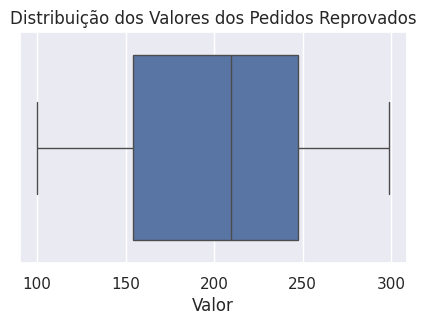

In [32]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='Valor', data=pedidos_reprovados_novo)
plt.title('Distribuição dos Valores dos Pedidos Reprovados')
plt.xlabel('Valor')
plt.show()

## Impacto financeiro e Escalabilidade da Solução

Valor para a amostra

In [33]:
print(f"Aumento de R${valor_total_reprovados - valor_total_reprovados_novo:.2f} em valor total recebido")
print(f"Considerando valores pagos, a empresa aumentaria R${valor_total_reprovados - valor_total_reprovados_novo - custo_total:.2f} em valor líquido recebido na amostra atual")

Aumento de R$9414.00 em valor total recebido
Considerando valores pagos, a empresa aumentaria R$3414.00 em valor líquido recebido na amostra atual


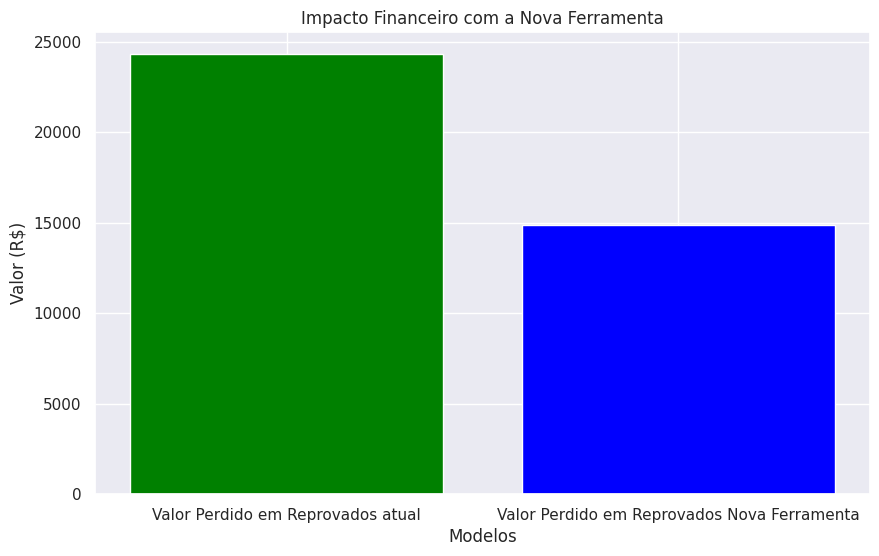

In [34]:

# Dados para o gráfico
categorias = ['Valor Perdido em Reprovados atual', 'Valor Perdido em Reprovados Nova Ferramenta']
valores = [valor_total_reprovados, valor_total_reprovados_novo]

plt.figure(figsize=(10, 6))
plt.bar(categorias, valores, color=['green', 'blue'])
plt.title('Impacto Financeiro com a Nova Ferramenta')
plt.xlabel('Modelos')
plt.ylabel('Valor (R$)')
plt.show()


Estimativas a partir de Expansão em Número de Pedidos

Iremos propor a análise do valor esperado para o valor recebido em pedidos a partir do uso da nova ferramenta e utilizando o modelo atual. Consideraremos a média de valor de valores aprovados e a taxa de aprovação apresentadas pelos modelos na amostra.

$Valor Esperado = numeroPedidos \times mediaValorAprovados \times taxaAprovacao - (numeroPedidos \times custo)$

$Valor Esperado Atual = numeroPedidos \times 199.47 \times 0.879$

$Valor Esperado Ferramenta = numeroPedidos \times 199.51 \times 0.926 - (numeroPedidos \times 6)$

In [35]:
def valor_esperado_atual(numero_pedidos):
  return numero_pedidos * 199.47 * 0.879

def valor_esperado_novo(numero_pedidos):
  return numero_pedidos * 199.51 * 0.926 - (numero_pedidos * 6)

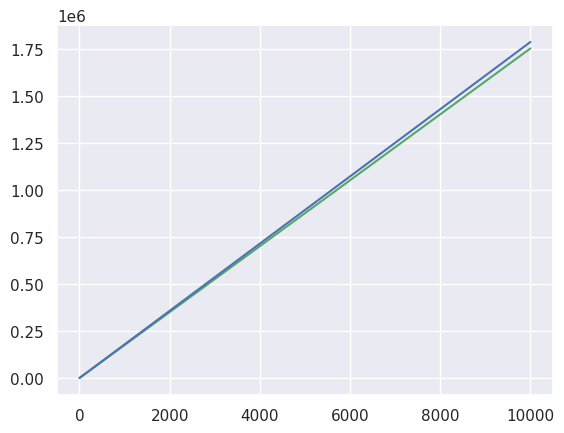

In [36]:
t = linspace(0, 10000, 400)

curva_atual = valor_esperado_atual(t)

curva_novo = valor_esperado_novo(t)

plt.plot(t, curva_atual, 'g')
plt.plot(t, curva_novo, 'b')
plt.show()

In [37]:
def plot_graph(max_ped):
    t = linspace(0, max_ped, 400)
    curva_atual = valor_esperado_atual(t)
    curva_novo = valor_esperado_novo(t)

    plt.figure(figsize=(10, 6))
    plt.plot(t, curva_atual, 'g', label="Valor Esperado Atual")
    plt.plot(t, curva_novo, 'b', label="Valor Esperado Novo")
    plt.xlabel('Número de Pedidos')
    plt.ylabel('Valor Esperado')
    plt.legend()
    plt.title('Gráfico Interativo')
    plt.show()

# Cria um slider para o valor máximo de t
interact(plot_graph, max_ped=FloatSlider(min=1000, max=10000, step=500, value=5000));

interactive(children=(FloatSlider(value=5000.0, description='max_ped', max=10000.0, min=1000.0, step=500.0), O…

Análise de ROI

In [38]:
roi = ((valor_total_reprovados - valor_total_reprovados_novo) - custo_total) / custo_total * 100

In [39]:
print(f"Retorno sobre o Investimento (ROI) da Nova Ferramenta: {roi:.2f}%")

Retorno sobre o Investimento (ROI) da Nova Ferramenta: 56.90%
